In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
%matplotlib widget 

import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import pandas as pd
import numpy as np
import hyperopt
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from pylab import *
pd.set_option('display.max_rows', 500)

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)
    
    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [4]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 7, subsample = 1, verbosity = 0)
    xgb.fit(X_train, y_train)

    return xgb

In [5]:
def train_classifier_DNN(X_train, y_train): 
    size = (50,) * 2
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='tanh',
                        solver='adam', learning_rate='invscaling', max_iter=1000)
    dnn.fit(X_train, y_train)

    return dnn

In [6]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=43, p=1, n_neighbors=14)
    knn.fit(X_train, y_train)

    return knn

In [7]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 

In [8]:
noise_intervals = [20, 60, 120, 300, 600]
noise_lengths = [3, 5, 7, 15]
noise_means = [1, 3, 5, 7, 12]

A_XGB = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GP_XGB = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GR_XGB = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GF1_XGB = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])

A_DNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GP_DNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GR_DNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GF1_DNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])

A_KNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GP_KNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GR_KNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GF1_KNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])

def training_loop(noise_lengths, noise_intervals, noise_means):
    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    lbl = [0, 1]
    label_names=['Attenuation', 'Filtering']

    spacing = 1
    w_length = 10
    sampling = 1
    
    for i, n_interval in enumerate(noise_intervals): #enumerate(range(minsp,maxsp+1,stepsp)):
        for j, n_length in enumerate(noise_lengths): #enumerate(range(minlength,maxlength+1,steplength)):
            for m, n_mean in enumerate(noise_means):
                print('********************************')
                print('Iteration for spacing={}; window length={}; noise interval={}; noise length={}; noise mean={}'.format(spacing, w_length, n_interval, n_length, n_mean))

                ####### 1) Load dataset #######
                print('1) Loading dataset into (XX,yy)...')

                XX = None
                yy = None
                folderpath='../Features_1_3'

                for filename in os.listdir(folderpath):
                    if filename.endswith('_nm' + str(n_mean) + '_ni' + str(n_interval) + '_nl' + str(n_length) 
                                         + '_sa' + str(sampling) + '_sp' + str(spacing) + '_w' + str(w_length) + '.dat'):
                        label = 0
                        if int(filename[9]) > 5:
                            label = 1
                        fullname = folderpath + '/' + filename
                        XX, yy = load_window_dataset(XX, yy, fullname, label)

                scaler = StandardScaler()
                XX = scaler.fit_transform(XX)

                X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.99, random_state=42)
                print('Training XGB...')
                xgb = train_classifier_XGB(X_train, y_train)

                print('Training DNN...')
                dnn = train_classifier_DNN(X_train, y_train)

                print('Training KNN...')
                knn = train_classifier_KNN(X_train, y_train)

                y_pred_XGB = xgb.predict(X_test)
                y_pred_DNN = dnn.predict(X_test)
                y_pred_KNN = knn.predict(X_test)

                A_XGB[i,j,m], GP_XGB[i,j,m], GR_XGB[i,j,m], GF1_XGB[i,j,m] = performance_eval(y_test, y_pred_XGB, lbl, label_names)
                print(A_XGB[i,j,m], GP_XGB[i,j,m], GR_XGB[i,j,m], GF1_XGB[i,j,m])
                A_DNN[i,j,m], GP_DNN[i,j,m], GR_DNN[i,j,m], GF1_DNN[i,j,m] = performance_eval(y_test, y_pred_DNN, lbl, label_names)
                print(A_DNN[i,j,m], GP_DNN[i,j,m], GR_DNN[i,j,m], GF1_DNN[i,j,m])
                A_KNN[i,j,m], GP_KNN[i,j,m], GR_KNN[i,j,m], GF1_KNN[i,j,m] = performance_eval(y_test, y_pred_KNN, lbl, label_names)
                print(A_KNN[i,j,m], GP_KNN[i,j,m], GR_KNN[i,j,m], GF1_KNN[i,j,m])


In [9]:
fig_folder = '1_3_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

training_loop(noise_lengths, noise_intervals, noise_means)

********************************
Iteration for spacing=1; window length=10; noise interval=20; noise length=3; noise mean=1
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.996206379191057 0.9962072179693163 0.996206379191057 0.9962042538561234
0.9899588247031051 0.9901036285898923 0.9899588247031051 0.9899206522105113
0.991441031740479 0.9915486883781262 0.991441031740479 0.9914132127504197
********************************
Iteration for spacing=1; window length=10; noise interval=20; noise length=3; noise mean=3
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9961545537701698 0.9961549913578274 0.9961545537701698 0.9961525333704997
0.9879894587093916 0.9880275886102324 0.9879894587093916 0.987959226610369
0.9919126430705525 0.9920098645518591 0.9919126430705525 0.9918877400299229
********************************
Iteration for spacing=1; window length=10; noise interval=20; noise length=3; noise mean=5
1) Loading 

Training XGB...
Training DNN...
Training KNN...
0.9945609220778884 0.9945708349803771 0.9945609220778884 0.9945544146988845
0.9802933837076424 0.9803610721533689 0.9802933837076424 0.9802187106478668
0.9837216352993307 0.984023264087465 0.9837216352993307 0.9836279330247228
********************************
Iteration for spacing=1; window length=10; noise interval=60; noise length=3; noise mean=1
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9973879987872851 0.9973877657187032 0.9973879987872851 0.9973878587059705
0.9921147622120127 0.9921589197973981 0.9921147622120127 0.9920970023411704
0.9928947347963649 0.9928917998331712 0.9928947347963649 0.9928908366802625
********************************
Iteration for spacing=1; window length=10; noise interval=60; noise length=3; noise mean=3
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9969448914386996 0.9969448289150734 0.9969448914386996 0.996944859269002
0.994947

Training XGB...
Training DNN...
Training KNN...
0.9961001370782383 0.9960995278747861 0.9961001370782383 0.996098649410278
0.9863284539699568 0.9863300797454035 0.9863284539699568 0.9863038592539035
0.9805965624198325 0.9809079502256006 0.9805965624198325 0.9804776484096218
********************************
Iteration for spacing=1; window length=10; noise interval=60; noise length=15; noise mean=12
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9944624537782027 0.9944610432046491 0.9944624537782027 0.9944615140045535
0.977720251560593 0.978435549605421 0.977720251560593 0.9775219561974541
0.9741028371826664 0.9746445139746228 0.9741028371826664 0.9738876340553801
********************************
Iteration for spacing=1; window length=10; noise interval=120; noise length=3; noise mean=1
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9976885862284309 0.9976884143855579 0.9976885862284309 0.9976884844134091
0.99436

Training XGB...
Training DNN...
Training KNN...
0.9949884818002078 0.9949869940369898 0.9949884818002078 0.9949872314617387
0.9888083003594093 0.9888621056296666 0.9888083003594093 0.9887778966237063
0.9824752339269935 0.9824846616329944 0.9824752339269935 0.9824312275460393
********************************
Iteration for spacing=1; window length=10; noise interval=120; noise length=15; noise mean=7
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9939519733824639 0.9939512547160141 0.9939519733824639 0.993951579476656
0.9911067577757566 0.991216883032785 0.9911067577757566 0.9910773351858375
0.9840740481613637 0.9841980001959106 0.9840740481613637 0.9840086848269137
********************************
Iteration for spacing=1; window length=10; noise interval=120; noise length=15; noise mean=12
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9956337082902534 0.9956406785303878 0.9956337082902534 0.9956294156361702
0.9

Training XGB...
Training DNN...
Training KNN...
0.9956984900663625 0.9956982711875083 0.9956984900663625 0.9956983747532144
0.9889819155193814 0.9890860590595163 0.9889819155193814 0.9889442697994504
0.9905133567065981 0.9905636950249709 0.9905133567065981 0.9904896111392678
********************************
Iteration for spacing=1; window length=10; noise interval=300; noise length=15; noise mean=5
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.996623573829199 0.9966229347652388 0.996623573829199 0.996623078630577
0.9918141747708669 0.9918564178679503 0.9918141747708669 0.9917958197924173
0.988194169121896 0.9883818740182979 0.988194169121896 0.9881423815536095
********************************
Iteration for spacing=1; window length=10; noise interval=300; noise length=15; noise mean=7
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.997242887608801 0.997244054988689 0.997242887608801 0.9972432933990285
0.99376021

Training XGB...
Training DNN...
Training KNN...
0.9955145098222129 0.9955144007138886 0.9955145098222129 0.9955144540022679
0.9923998020268923 0.9924259443690574 0.9923998020268923 0.9923857146122353
0.993125357919313 0.9931716306547853 0.993125357919313 0.9931101905067552
********************************
Iteration for spacing=1; window length=10; noise interval=600; noise length=15; noise mean=3
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9966650341659087 0.9966644522955133 0.9966650341659087 0.9966640897857361
0.9923324289797388 0.9923606358218542 0.9923324289797388 0.9923178053101166
0.992967290385607 0.9930127961473529 0.992967290385607 0.9929517812622201
********************************
Iteration for spacing=1; window length=10; noise interval=600; noise length=15; noise mean=5
1) Loading dataset into (XX,yy)...
Training XGB...
Training DNN...
Training KNN...
0.9975849353866565 0.9975846253388819 0.9975849353866565 0.9975844489561894
0.9906

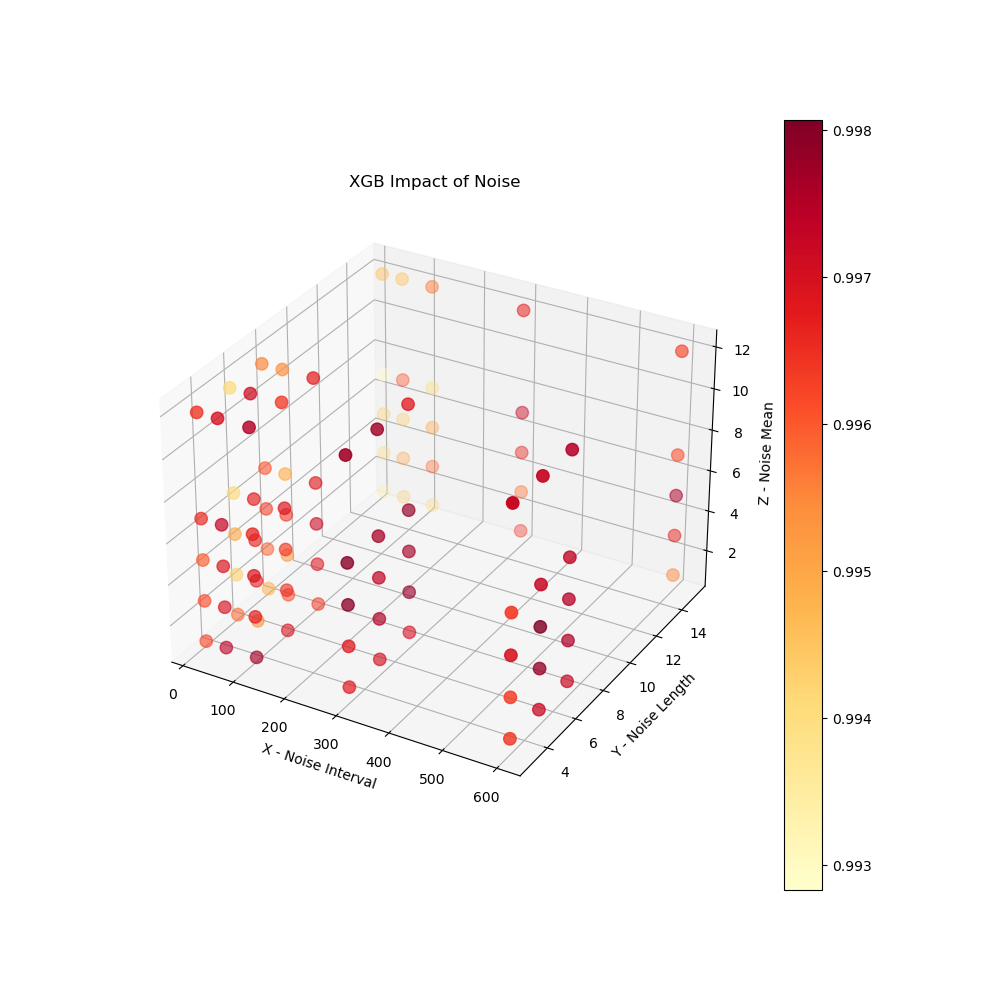

In [22]:
fig_folder = '1_3_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

noise_intervals_x = np.repeat(noise_intervals, len(noise_lengths)*len(noise_means))
noise_lengths_y = list(np.repeat(noise_lengths, len(noise_means))) * len(noise_intervals)
noise_means_z = noise_means * (len(noise_lengths)*len(noise_intervals))

A_XGB = A_XGB.reshape(-1)
GP_XGB = GP_XGB.reshape(-1)
GR_XGB = GR_XGB.reshape(-1)
GF1_XGB = GF1_XGB.reshape(-1)

A_DNN = A_DNN.reshape(-1)
GP_DNN = GP_DNN.reshape(-1)
GR_DNN = GR_DNN.reshape(-1)
GF1_DNN = GF1_DNN.reshape(-1)

A_KNN = A_KNN.reshape(-1)
GP_KNN = GP_KNN.reshape(-1)
GR_KNN = GR_KNN.reshape(-1)
GF1_KNN = GF1_KNN.reshape(-1)

df = pd.DataFrame(list(zip(noise_intervals_x, noise_lengths_y, noise_means_z, A_XGB)),
               columns =['X', 'Y', 'Z', 'Accuracy'])
#display(df)

# creating 3d figures
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111,projection='3d')

# Value Normalization
colors = cm.YlOrRd((A_XGB-min(A_XGB))/(max(A_XGB)-min(A_XGB)))
#colors = cm.hsv(A_XGB/(max(A_XGB)))
#colors = cm.hsv(A_XGB)

# configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.YlOrRd)
color_map.set_array(A_XGB)

# creating the heatmap
img = ax.scatter3D(noise_intervals_x, noise_lengths_y, noise_means_z, c=colors, marker='o', s=80)
plt.colorbar(color_map)

# adding title and labels
title = "XGB Impact of Noise"
ax.set_title(title)
ax.set_xlabel('X - Noise Interval')
ax.set_ylabel('Y - Noise Length')
ax.set_zlabel('Z - Noise Mean')

plt.show()
fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')

In [11]:
display(df)

,X,Y,Z,Accuracy
0,20,3,1,0.996206
1,20,3,3,0.996155
2,20,3,5,0.995927
3,20,3,7,0.996538
4,20,3,12,0.996460
5,20,5,1,0.995844
6,20,5,3,0.994291
7,20,5,5,0.994970
8,20,5,7,0.994113
9,20,5,12,0.994089
